<a href="https://colab.research.google.com/github/sarahgruetz/AluraChallenge_DS_2/blob/main/sistema-recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 49.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=50f55d367020e165813afa45b682c0101ad31810d3b6da2b3ab0f25adc7a774e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


### Iniciando a SparkSession

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Sistema de Recomendação") \
    .getOrCreate()

### Carregando dataset a partir do arquivo no drive

In [ ]:
import zipfile

zipfile.ZipFile('/content/drive/MyDrive/curso-spark/ChallengeAlura/semanas-3-e-4.zip','r')\
        .extractall('/content/drive/MyDrive/curso-spark/ChallengeAlura/dados')

In [ ]:
dataset = spark.read.parquet('/content/drive/MyDrive/curso-spark/ChallengeAlura/dados/dataset_ml_parquet')

In [ ]:
print(f'O dataset possui {dataset.count()} registros e {len(dataset.columns)} colunas.')

O dataset possui 66551 registros e 25 colunas.


In [ ]:
dataset.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|Santo Cristo|     100.0|100.0|245000.0|           1|         0|     

### Conferindo o tipos das variáveis

In [ ]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: double (nullable = true)
 |-- vaga: double (nullable = true)
 |-- bairro: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zona Sul: integer (nullable = true)
 |-- Academia: integer (nullable = true)
 |-- Animais permitidos: integer (nullable = true)
 |-- Churrasqueira: integer (nullable = true)
 |-- Condomínio fechado: integer (nullable = true)
 |-- Elevador: integer (nullable = true)
 |-- Piscina: integer (nullable = true)
 |-- Playground: integer (nullable = true)
 |-- Portaria 24h: integer (nullable = true)
 |-- Portão eletrônico: integer (nullable 

### Conferindo se existem valores faltantes

In [ ]:
from pyspark.sql import functions as f

In [ ]:
dataset\
  .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
  .show(vertical=True)

-RECORD 0-----------------
 id                 | 0   
 andar              | 0   
 area_util          | 0   
 banheiros          | 0   
 quartos            | 0   
 suites             | 0   
 vaga               | 0   
 bairro             | 0   
 condominio         | 0   
 iptu               | 0   
 valor              | 0   
 Zona Central       | 0   
 Zona Norte         | 0   
 Zona Oeste         | 0   
 Zona Sul           | 0   
 Academia           | 0   
 Animais permitidos | 0   
 Churrasqueira      | 0   
 Condomínio fechado | 0   
 Elevador           | 0   
 Piscina            | 0   
 Playground         | 0   
 Portaria 24h       | 0   
 Portão eletrônico  | 0   
 Salão de festas    | 0   



### Renomeando colunas
Removendo espaços e acentos

In [ ]:
novos_nomes = [
      'id',
      'andar',
      'area_util',
      'banheiros',
      'quartos',
      'suites',
      'vaga',
      'bairro',
      'condominio',
      'iptu',
      'valor',
      'zona_central',
      'zona_norte',
      'zona_oeste',
      'zona_sul',
      'academia',
      'animais_permitidos',
      'churrasqueira',
      'condominio_fechado',
      'elevador',
      'piscina',
      'playground',
      'portaria_24h',
      'portao_eletronico',
      'salao_festas'
      ]

In [ ]:
mapa_renomear = zip(dataset.columns,novos_nomes)

In [ ]:
for antigo, novo in mapa_renomear:
  dataset = dataset.withColumnRenamed(antigo, novo)

dataset.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'bairro',
 'condominio',
 'iptu',
 'valor',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul',
 'academia',
 'animais_permitidos',
 'churrasqueira',
 'condominio_fechado',
 'elevador',
 'piscina',
 'playground',
 'portaria_24h',
 'portao_eletronico',
 'salao_festas']

### Preparando os dados
Para utilização dos dados no modelo de clusterização é preciso fazer a seleção das variáveis que vão ser utilizadas pelo modelo e a transformação desse dataset para o formato adequado para os modelos do `pyspark.ml`

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
dataset.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'bairro',
 'condominio',
 'iptu',
 'valor',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul',
 'academia',
 'animais_permitidos',
 'churrasqueira',
 'condominio_fechado',
 'elevador',
 'piscina',
 'playground',
 'portaria_24h',
 'portao_eletronico',
 'salao_festas']

#### Selecionando as variáveis que vão ser utilizados no modelo
As variáveis `id` e `bairro`, por estarem em formato de string, não serão utilizadas

In [ ]:
X = dataset.drop('id','bairro').columns

#### Transformando o dataset

In [ ]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
dataset_modelo = assembler.transform(dataset).select('features')

In [ ]:
dataset_modelo.show(5, False)

+------------------------------------------------------------------------------------------------------------+
|features                                                                                                    |
+------------------------------------------------------------------------------------------------------------+
|[2.0,35.0,1.0,1.0,0.0,0.0,100.0,100.0,245000.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]     |
|(23,[0,1,2,3,5,6,7,8,10,15,17,19,20,22],[1.0,84.0,2.0,2.0,1.0,770.0,105.0,474980.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(23,[1,2,3,6,7,8,12,14,17],[85.0,2.0,2.0,460.0,661.0,290000.0,1.0,1.0,1.0])                                 |
|(23,[1,2,3,5,6,7,8,11,18,19],[58.0,1.0,2.0,1.0,550.0,550.0,249000.0,1.0,1.0,1.0])                           |
|(23,[1,2,3,4,5,6,8,10],[64.0,2.0,2.0,1.0,1.0,850.0,530000.0,1.0])                                           |
+------------------------------------------------------------------------------------------------------------+
o

### Padronização dos dados

Para realizar a clusterização dos dados é preciso que as variáveis tenham valores mais próximos uma das outras. Uma forma de se obter isso é utilizando o StandardScaler que realiza a padronização dos dados subtraindo cada coluna por sua média e dividindo pelo seu desvio padrão. Dessa forma, a distribuição de todas as variáveis terá uma média zero e desvio padrão igual a um.

In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(dataset_modelo)
dataset_modelo_scaler = scaler_model.transform(dataset_modelo)   # fit_transform (?)

In [ ]:
dataset_modelo_scaler.select('scaled_features').show(5,False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Redução de dimensionalidade

O objetivo da redução de dimensionalidade é manter a maior representatividade dos dados com a menor quantide possível de variáveis. Para fazer isso foi utilizado o PCA.

Primeiro encontramos a quantidade ideal de componentes.

In [ ]:
from pyspark.ml.feature import PCA

Total de variáveis no dataset

In [ ]:
k = len(X)
k

23

Transformando os dados usando 23 componentes

In [ ]:
pca = PCA(k=k, inputCol='scaled_features', outputCol='pca_features')
model_pca = pca.fit(dataset_modelo_scaler)

Os valores a seguir mostram quanto da variância dos dados é explicada com uma quantidade k de componentes.

Por exemplo, com 10 componentes mais de 85% da variância nos dados já é explicada.

In [ ]:
[(i,sum(model_pca.explainedVariance[0:i+1])) for i in range(k)]

[(0, 0.26545749360997034),
 (1, 0.4375247949776184),
 (2, 0.5287992767783259),
 (3, 0.5831729986362391),
 (4, 0.6354028103524717),
 (5, 0.682023156221161),
 (6, 0.7262890569978575),
 (7, 0.7678911881686676),
 (8, 0.8025730095613413),
 (9, 0.8297996535128337),
 (10, 0.854194399626073),
 (11, 0.8742987112956476),
 (12, 0.8935090265260494),
 (13, 0.9111213166740558),
 (14, 0.9266283824348652),
 (15, 0.9405231608927351),
 (16, 0.9525305733295567),
 (17, 0.9638657310284791),
 (18, 0.9739753651565556),
 (19, 0.983205487506614),
 (20, 0.9921039340092773),
 (21, 0.9999999999999953),
 (22, 1.0)]

Obtendo a quantidade mínima de componentes para se ter em torno de 70% da variância explicada. Ou seja, a melhor troca entre a redução de dimensionalidade sem grandes perdas na representatividade.

In [ ]:
import numpy as np

cumulative_sum = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]
k = sum(np.array(cumulative_sum) <= 0.7)
k

6

Transformando novamente os dados, agora usando apenas 6 componentes.

In [ ]:
pca = PCA(k=k, inputCol='scaled_features', outputCol='pca_features')
model_pca = pca.fit(dataset_modelo_scaler)
dataset_modelo_pca = model_pca.transform(dataset_modelo_scaler)

In [ ]:
dataset_modelo_pca.select('pca_features').show(5, False)

+--------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------+
|[-6.165125049533812,1.3380985269405696,-1.7052299823820158,-0.5338289630560162,0.08903815478581815,-0.3134396180129953]   |
|[-3.2529111812184865,-1.1179591836228857,-0.2923895841501507,3.195538820020636,0.1528630698219846,1.302893049066197]      |
|[-1.0611769329629537,-1.6685040058694294,-2.30759482783911,0.10553124125788461,-0.06914386452866851,0.7187181899556143]   |
|[-1.995811900783872,-1.7655796610847843,1.3571962498672347,-0.16336519381168974,-0.021305227846957334,0.12808044918214828]|
|[-0.4181406070145923,-2.131040791141693,-0.1026409926497008,2.809916415039177,-0.042956284698168964,-0.09449068767336455] |


### Criando um pipeline

Para estruturar melhor todas as transformações feitas nos dados até aqui, é possível criar um pipeline desse processo. O pipeline facilita a aplicação das transformações, já que organiza elas para aplicação de forma sequencial.

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols=X, outputCol='features'),
                                StandardScaler(inputCol='features', outputCol='scaled_features'),
                                PCA(k=6, inputCol='scaled_features', outputCol='pca_features')])

Transformando novamente os dados, agora usando o pipeline

In [ ]:
pca_pipeline_model = pca_pipeline.fit(dataset)

In [ ]:
dados_pipeline_model = pca_pipeline_model.transform(dataset)

Teremos o mesmo resultado obtido anteriormente, mas agora de forma mais concisa.

In [ ]:
dados_pipeline_model.select('pca_features').show(5, False)

+--------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------+
|[-6.165125049533812,1.3380985269405696,-1.7052299823820158,-0.5338289630560162,0.08903815478581815,-0.3134396180129953]   |
|[-3.2529111812184865,-1.1179591836228857,-0.2923895841501507,3.195538820020636,0.1528630698219846,1.302893049066197]      |
|[-1.0611769329629537,-1.6685040058694294,-2.30759482783911,0.10553124125788461,-0.06914386452866851,0.7187181899556143]   |
|[-1.995811900783872,-1.7655796610847843,1.3571962498672347,-0.16336519381168974,-0.021305227846957334,0.12808044918214828]|
|[-0.4181406070145923,-2.131040791141693,-0.1026409926497008,2.809916415039177,-0.042956284698168964,-0.09449068767336455] |


### Criando os clusters

Para criação dos clusters será utilizado o KMeans, um algoritmo não supervisionado que separa os dados em um número k de clusters informado previamente, agrupando dados com características semelhantes. 

In [ ]:
from pyspark.ml.clustering import KMeans

Primeiro vamos calcular utilizar o custo para calcular a quantidade mais adequada de clusters para esse dataset, analisando valores entre 2 e 40.

In [ ]:
costs = {}
for k in range(2, 40):
    k_means = KMeans(featuresCol='pca_features', k=k, seed=101)
    model = k_means.fit(dados_pipeline_model)
    costs[k] = model.summary.trainingCost

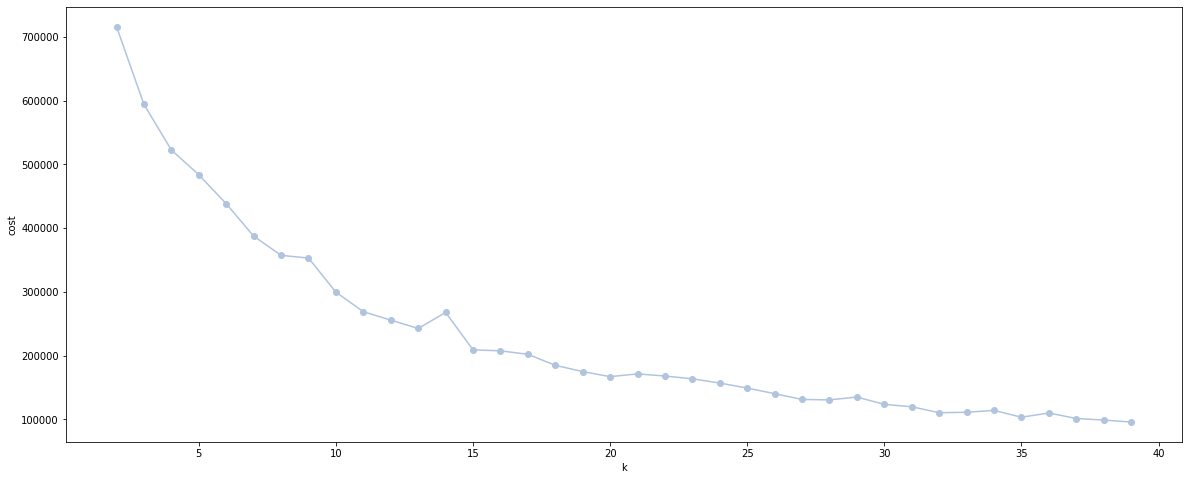

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize =(20, 8))

ax.plot(list(costs.keys()), list(costs.values()),**{'color': 'lightsteelblue', 'marker': 'o'})
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

Analisando o gráfico, 13 clusters parece ser um número adequado pare esse dataset. Esse valor aparece antes de um pequeno pico no gráfico, que logo depois quase se estabiliza.

In [ ]:
kmeans = KMeans(k=13, featuresCol='pca_features', predictionCol='cluster_pca', seed=101)

In [ ]:
model_kmeans = kmeans.fit(dados_pipeline_model)

In [ ]:
predictions_kmeans = model_kmeans.transform(dados_pipeline_model)

In [ ]:
predictions_kmeans.select('id', 'cluster_pca').show(5,False)

+------------------------------------+-----------+
|id                                  |cluster_pca|
+------------------------------------+-----------+
|00002dd9-cc74-4809-b5a5-850adf0e7526|8          |
|0009ca94-2b37-4381-b8b8-773ce0f92444|10         |
|000e3d28-e3e5-4110-b488-69154931140e|6          |
|000fb707-6cad-496d-8cb7-d8046cb5ef37|1          |
|001b6db0-e88d-4eba-84e5-0ef94b091a64|10         |
+------------------------------------+-----------+
only showing top 5 rows



### Avaliando as informações de cada cluster

#### Quantidade de dados em cada cluster

A quantidade varia bastante com alguns clusters tendo 13 dados e outros mais de 10 mil.

In [ ]:
predictions_kmeans.groupBy('cluster_pca').count().orderBy('cluster_pca').show(13)

+-----------+-----+
|cluster_pca|count|
+-----------+-----+
|          0| 3834|
|          1| 7417|
|          2| 5650|
|          3| 6616|
|          4|   87|
|          5| 3366|
|          6|10079|
|          7| 2449|
|          8|14808|
|          9| 4389|
|         10| 5897|
|         11|   13|
|         12| 1946|
+-----------+-----+



#### Analisando a média dos clusters para algumas variáveis

In [ ]:
cluster_means = predictions_kmeans\
                              .groupBy('cluster_pca')\
                              .mean()

#### Area Útil
Os clusters 11 e 5 possuem as maiores médias de área útil (mais que 300 m2).

Já os clusters 0 e 2 têm as menores médias de área útil (menos que 80 m2).

In [ ]:
cluster_means\
          .orderBy('avg(area_util)')\
          .withColumn('Area Útil', f.round(cluster_means['avg(area_util)'],2))\
          .select('cluster_pca','Area Útil')\
          .show()

+-----------+---------+
|cluster_pca|Area Útil|
+-----------+---------+
|          0|    73.05|
|          2|    79.81|
|         12|     82.0|
|         10|    87.56|
|          8|    88.24|
|          3|    94.22|
|          1|    95.67|
|          6|   108.76|
|          4|   142.59|
|          7|   187.53|
|          9|   247.66|
|          5|   315.91|
|         11|   330.77|
+-----------+---------+



### Valor

Os clusters 11 e 5, que possuem as maiores médias de área útil, também são os clusters que possuem os imóveis com os maiores valores de venda. Porém os clusters 0 e 2, que possuem as menores médias de área, não são os mais baratos. Os clusters com as menores médias de preço de venda são os clusters 12 e 10. 

In [ ]:
cluster_means\
          .orderBy('avg(valor)')\
          .withColumn('Valor', f.round(cluster_means['avg(valor)'],2))\
          .select('cluster_pca','Valor')\
          .show()

+-----------+----------+
|cluster_pca|     Valor|
+-----------+----------+
|         12|  447808.3|
|         10| 511368.32|
|          0| 516034.35|
|          2| 688634.65|
|          1| 778950.67|
|          8| 843393.71|
|          3|1177206.71|
|          6|1489519.18|
|          4|1797019.28|
|          7|2239334.39|
|          9|3371214.55|
|          5|4401872.65|
|         11|5349143.08|
+-----------+----------+



#### Quartos
Nenhum cluster tem uma média menor que 2 quartos. A maior média de número de quartos pertence ao cluster 5, que também é um dos clusters com as maiores médias de área útil e valor.

In [ ]:
cluster_means\
          .orderBy('avg(quartos)')\
          .withColumn('Quartos', f.round(cluster_means['avg(quartos)'],2))\
          .select('cluster_pca','Quartos')\
          .show()

+-----------+-------+
|cluster_pca|Quartos|
+-----------+-------+
|          3|   2.19|
|         12|   2.27|
|          2|    2.3|
|          0|    2.3|
|         10|   2.41|
|          8|   2.43|
|          1|   2.45|
|          6|   2.52|
|          4|   2.86|
|         11|   3.54|
|          7|   3.65|
|          9|   3.83|
|          5|   3.94|
+-----------+-------+



#### Banheiros
Na média de quantidade de banheiros, novamente o cluster 5 aparece com o maior valor. O cluster 12, que possui a menor média de valor de venda, também tem uma das menores médias de quantidade de quartos e quantidade de banheiros.

In [ ]:
cluster_means\
          .orderBy('avg(banheiros)')\
          .withColumn('Banheiros', f.round(cluster_means['avg(banheiros)'],2))\
          .select('cluster_pca','Banheiros')\
          .show()

+-----------+---------+
|cluster_pca|Banheiros|
+-----------+---------+
|          0|     1.81|
|         12|     1.84|
|          3|     1.94|
|          2|      2.0|
|         10|     2.05|
|          8|     2.11|
|          1|     2.17|
|          6|      2.2|
|          4|     2.86|
|         11|     3.92|
|          7|     4.11|
|          9|     4.55|
|          5|      5.0|
+-----------+---------+



### Filtrando imoveis do mesmo cluster
Para criar um sistema de recomendação o primeiro passo é selecionar todos os imóveis que pertencem ao mesmo cluster que o imóvel que escolhemos de referência.

In [ ]:
id_imovel = '026d4cd2-7843-4420-b078-a81c384724e1'

Esse imóvel pertence ao cluster 6.

In [ ]:
cluster = predictions_kmeans.filter(predictions_kmeans.id == id_imovel).select('cluster_pca').collect()[0][0]
cluster

6

Outros 10 mil imóveis também foram agrupados no cluster 6.

In [ ]:
imoveis_cluster = predictions_kmeans.filter(predictions_kmeans.cluster_pca == cluster)
print(imoveis_cluster.count())
imoveis_cluster.show(5)

10079
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+--------------------+--------------------+--------------------+-----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|    valor|zona_central|zona_norte|zona_oeste|zona_sul|academia|animais_permitidos|churrasqueira|condominio_fechado|elevador|piscina|playground|portaria_24h|portao_eletronico|salao_festas|            features|     scaled_features|        pca_features|cluster_pca|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+

### Calculando a distância euclidiana
Para escolher os imóveis dentro desse cluster que são mais parecidos com nosso imóvel de referência, vamos utilizar as componentes do PCA para calcular a distância desse imóvel em relação a todos os outros do mesmo cluster.

In [ ]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

Vetor com as componentes do nosso imóvel de referência

In [ ]:
componentes_imovel = predictions_kmeans.filter(predictions_kmeans.id == id_imovel).collect()[0]['pca_features']
componentes_imovel

DenseVector([-1.3808, -2.7878, -2.5876, 0.1884, -0.0829, 0.7213])

Criando uma função para facilitar o cálculo para todos os registros do dataframe.

udf = user defined function (função python, returnType)

In [ ]:
def calcula_distance(value):
  # função que recebe as componentes PCA de um imóvel e retorna a distância euclidiana entre esse imóvel e o imóvel de referência
  return euclidean(componentes_imovel, value)

udf_calcula_distance = f.udf(calcula_distance, FloatType())

In [ ]:
imoveis_recomendados_dist = imoveis_cluster.withColumn('distancia', udf_calcula_distance('pca_features'))

In [ ]:
imoveis_recomendados_dist.select('id','distancia').show(10)

+--------------------+---------+
|                  id|distancia|
+--------------------+---------+
|000e3d28-e3e5-411...|1.2001938|
|005c608c-5afc-459...|1.7537957|
|0092be3c-1736-42a...|2.8968287|
|00cd6c5d-592d-429...|2.8072562|
|00d01937-9bca-45a...|1.9423105|
|00fafb28-3930-4b6...|3.0215576|
|00fcb5fb-c01b-44b...| 1.761932|
|00ff8cc4-306e-48a...|2.0713084|
|01228c26-3a13-480...|2.2284024|
|01259581-b96b-4ce...|1.7095782|
+--------------------+---------+
only showing top 10 rows



Selecionando os 10 imóveis com a menor distância.

O primeiro imóvel, com distância zero, é nosso imóvel de referência.

In [ ]:
recomendados = spark.createDataFrame(imoveis_recomendados_dist.sort('distancia').take(10)).select(['id', 'distancia'])
recomendados.show()

+--------------------+-------------------+
|                  id|          distancia|
+--------------------+-------------------+
|026d4cd2-7843-442...|                0.0|
|f1b69b17-4fcc-450...|0.13514484465122223|
|fa87df41-f2d5-472...|0.15378379821777344|
|8113c794-4899-4aa...|0.16914920508861542|
|f2f232ae-3840-487...|0.17055851221084595|
|32c63c10-f039-4c2...| 0.1714104413986206|
|a0ee0a7c-6093-42e...|0.17479223012924194|
|43435809-13dd-4a7...|0.17544682323932648|
|1448ad72-6d37-420...|0.17663204669952393|
|9ffb5f7d-807d-411...|0.18794573843479156|
+--------------------+-------------------+



### Criando uma função recomendadora

Para facilitar a recomendação de imóveis para qualquer id, criamos uma função aplicando o mesmo processo mostrado anteriormente.

In [ ]:
def recomendador(id_imovel:str):
  # função que recebe o id de um imóvel e retorna os 10 imóveis mais semelhantes
  cluster = predictions_kmeans.filter(predictions_kmeans.id == id_imovel).collect()[0]['cluster_pca']
  print('Esse imóvel pertence ao cluster', cluster)
  imoveis_mesmo_cluster = predictions_kmeans.where(predictions_kmeans.cluster_pca == cluster)
  imoveis_recomendados_dist = imoveis_mesmo_cluster.withColumn('distancia', udf_calcula_distance('pca_features'))
  recomendados = spark.createDataFrame(imoveis_recomendados_dist.sort('distancia').take(10))
  recomendados.drop('features','scaled_features','pca_features','distancia','cluster_pca').show()

In [ ]:
recomendador('026d4cd2-7843-4420-b078-a81c384724e1')

Esse imóvel pertence ao cluster  6
+--------------------+-----+---------+---------+-------+------+----+----------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|    bairro|condominio|  iptu|    valor|zona_central|zona_norte|zona_oeste|zona_sul|academia|animais_permitidos|churrasqueira|condominio_fechado|elevador|piscina|playground|portaria_24h|portao_eletronico|salao_festas|
+--------------------+-----+---------+---------+-------+------+----+----------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+
|026d4cd2-7843-442...|    1|      110|        2|      2|   1.0| 1.0|    Leblon|    1850.0|5064.0|1850000.0|   